<h1>SC1015 Mini Project</h1>

<h2>Part 2: Data Preparation</h2>

Through the observations produced from Exploratory Data Analysis, we have gained a better understanding of our data. But before embarking on predictive modeling, we first need to clean and preprocess the data such that it is more easily parsed by the classifier model during the training stage, which:
- Improves model accuracy
- Improves time efficiency in training the model
- Prevents overfitting

In [2]:
# load previous session
import dill
dill.load_session('notebook_env.db')

<h3>Data Cleaning</h3>

From our observations on the predictor `thal`, there appears to be a class `0` which is not mentioned in the description of the dataset.

In [3]:
df['thal'].value_counts()

2    544
3    410
1     64
0      7
Name: thal, dtype: int64

There are seven instances of `thal = 0`. These are the samples where `thal` was not recorded, and therefore it is MNAR (Missing Not As Random), meaning our observed samples cannot explain the missing data. Therefore, we cannot simply remove the samples with `thal = 0`, especially since these samples may contain useful information for training our model. There is a need for data imputation.

Unvariate methods for missing data imputation, like the mean/median/mode, are simplistic ways of estimating the value of the missing data, and may not provide an accurate depiction of the sample in relation to its other variables. As such, we will use Sci-Kit Learn's <b>KNNImputer</b>, which identifies neighboring samples similar to the incomplete sample to provide an estimation for the missing data.

In [4]:
# initialize KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# convert `thal = 0` values to NaN
df['thal'] = df['thal'].convert_dtypes()
df.loc[df['thal'] == 0, 'thal'] = np.NaN

# use KNNImputer
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)
df_imputed['thal'] = np.round(df_imputed['thal'])
df_imputed = df_imputed.astype(df.dtypes.to_dict()) # retain data types from original dataset

In [5]:
df_imputed['thal'].value_counts()

2    551
3    410
1     64
Name: thal, dtype: Int64

<br>

From our observations on the predictor `ca`, there appears to be a class `4` which is not mentioned in the description of the dataset.

In [6]:
df_imputed['ca'].value_counts()

0    578
1    226
2    134
3     69
4     18
Name: ca, dtype: int64

There are 18 instances of `ca = 4`, which account for approximately 1% of the samples. Unlike the previous example with `thal = 0` where we clearly know that it is missing data, here `ca = 4` has some meaning that we do not know. Refer back to the definition for `ca`: it is the number of major vessels colored by fluoroscopy from 0 ~ 3. Therefore, `ca = 4` does not make sense in the context of this definition for `ca`.

By analyzing the dataset, we realize that `ca = 4` can be complained explained by the `sex` variable: every sample with `ca = 4` has `sex = 1` AKA male patients. This is an observation that is unique to `ca = 4`.

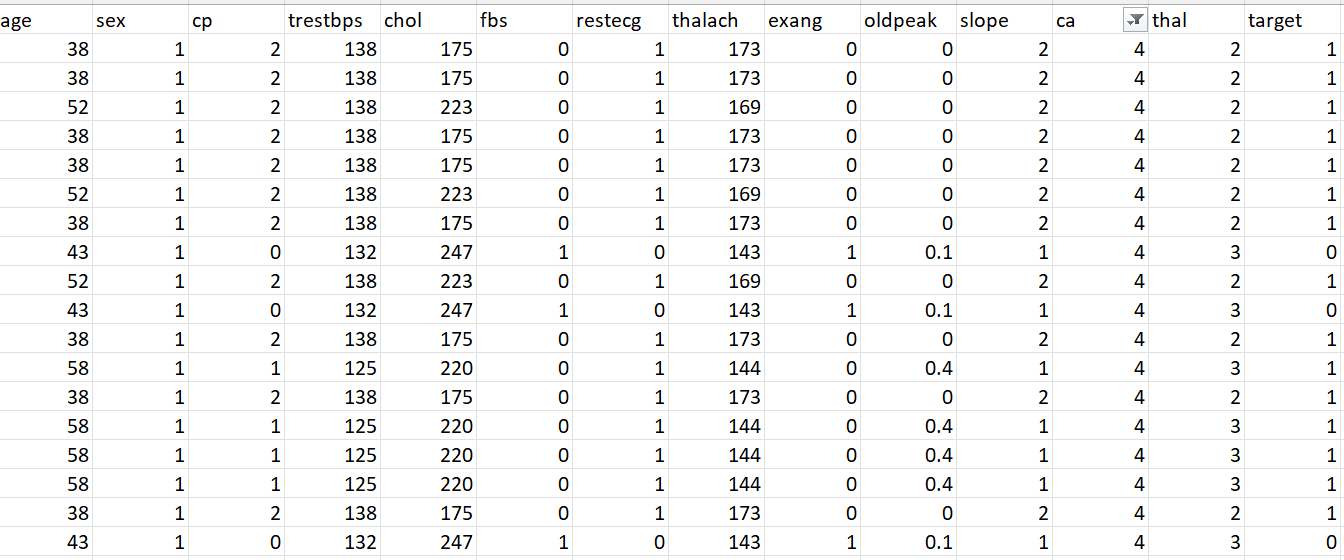

As such, it would not be accurate to replace the samples with `ca = 4` via data imputation, as it has a relationship with another variable. This relationship may influence how the classifier model is trained and predicts heart disease, and as such, we have decided to delete these samples from the dataset, since:
1. We cannot make assumptions of the meaning for `ca = 4` and therefore this particular class would not be able to contribute any value for the predictive model, and;
2. As there are only 18 samples for `ca = 4` which constitute 1% of the total dataset, removal of the samples will not be a huge loss for the predictive accuracy of the model.

In [7]:
df_imputed = df_imputed[df_imputed.ca != 4]
df_imputed['ca'].value_counts()

0    578
1    226
2    134
3     69
Name: ca, dtype: int64

<h3>Fitting Data to Normal Distribution</h3>

Here we are transforming the skewed data distributions identified during EDA to fit a normal distribution. A <b>normal distribution</b> is a nearly perfectly symmetrical distribution characterized by the mean, median and mode being close together, and the shape of the distribution can be seen as a bell curve. In machine learning, the normal distribution simplifies the model training process and leads to more precise predictions, and many predictive models in fact expect features with continuous data to follow a normal distribution, as this is the most simple yet natural form that a data distribution can take.

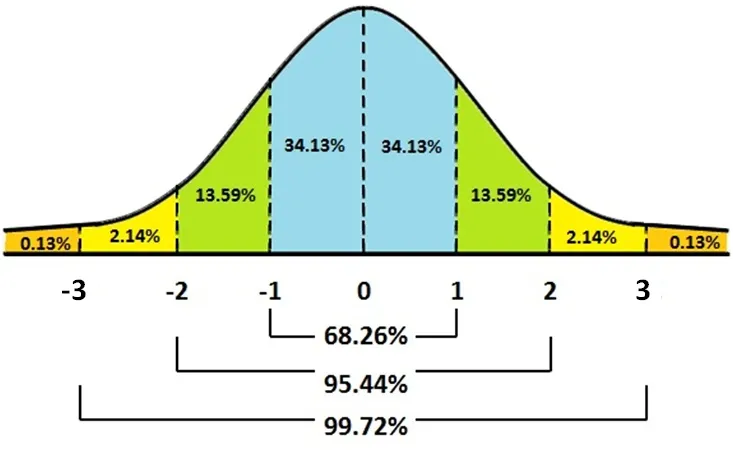

https://medium.com/analytics-vidhya/normal-distribution-and-machine-learning-ec9d3ca05070

`chol`, `oldpeak` and `trestbps` have been identified earlier to be skewed beyond our acceptable range for skewness. Therefore, we will apply transformations on these columns such that the data fits a normal distribution better. As all these features are <b>positively-skewed</b>, we can consider applying the log transformation.

In [8]:
# temporary list
skew_list = ['chol', 'oldpeak', 'trestbps']
df_trans = df_imputed.copy()

for feature in skew_list:
    df_trans[feature] = np.log(df_trans[feature])

C:\Users\ymtbr\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Once the data has been transformed, now let's look at the distributions.

Blue: Before log transform
Green: After log transform


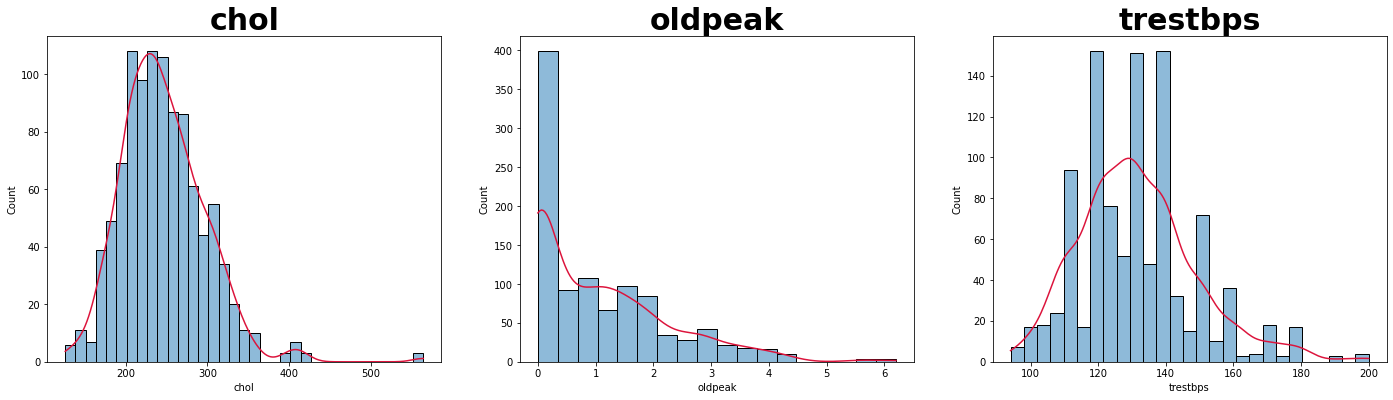

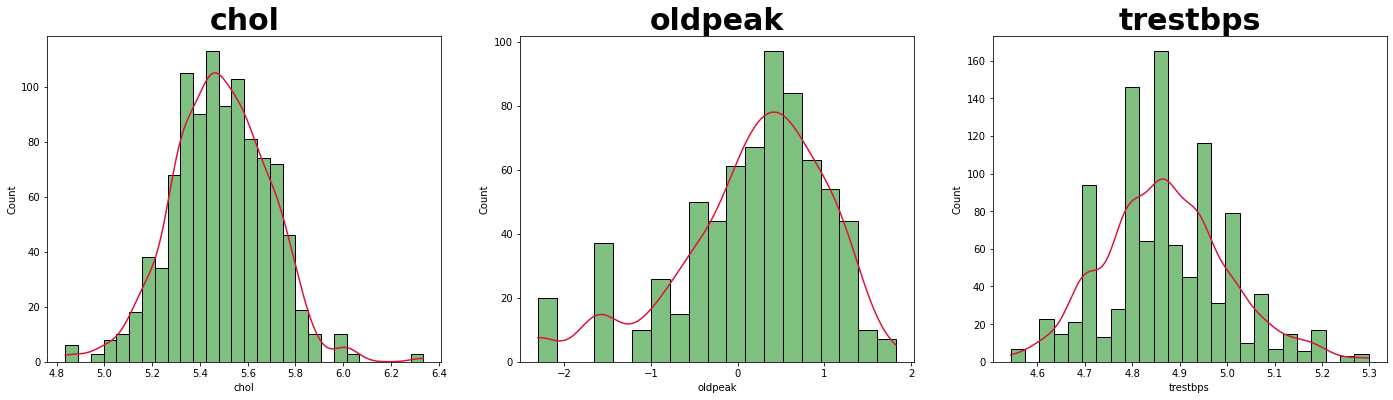

In [9]:
f, axes = plt.subplots(1, 3, figsize=(24,6))
print("Blue: Before log transform")
print("Green: After log transform")

count = 0
for feature in skew_list:
    g = sb.histplot(data=df_new[feature], ax=axes[count], kde=True)
    g.set_title(feature, fontdict={'fontsize':30, 'fontweight':'bold'})
    g.lines[0].set_color('crimson')
    count+=1

# after normalization
f, axes = plt.subplots(1, 3, figsize=(24,6))

count = 0
for feature in skew_list:
    g = sb.histplot(data=df_trans[feature], ax=axes[count], kde=True, color='green')
    g.set_title(feature, fontdict={'fontsize':30, 'fontweight':'bold'})
    g.lines[0].set_color('crimson')
    count+=1

The log transform has successfully fitted the data distributions for `chol`, `oldpeak` and `trestbps` closer to a normal distribution. 

<h3>Data Standardization + One-Hot Encoding</h3>

We will now perform data standardization and one-hot encoding on the dataset.

<b>Data Standardization</b> using the `StandardScaler` rescales the features to have a mean = 0 and standard deviation = 1. This is to "standardize" the scale among all the features such that each feature is equally important when training the predictive model, as the model may place more weight on features with a larger range.

<b>One-Hot Encoding</b> encodes the categorical variables into a numerical form. For example, the categorical variable `thal` with three classes is transformed under OHE into `thal_1`, `thal_2` and `thal_3`, which are binary variables for each of the classes of `thal`. Many machine learning models cannot work on categorical data directly unless it is transformed into a numerical equivalent, and thus some sort of encoding is important. 

OHE is especially important for variables without an ordinal relationship, as without OHE the model may assume some sort of ordering based on the classes which will lead to erroneous results. For example, the variable `sex` has Male as 1 and Female as 0. Does this mean Male > Female? No, but the model may assume an order. Therefore, OHE is an essential step.

In [10]:
from sklearn.preprocessing import StandardScaler

# initialize scaler
scaler = StandardScaler()

# scale and encode columns
scaled_cols = scaler.fit_transform(df_imputed[cont]) 
ohe_cols = pd.get_dummies(df_imputed[cat], columns = cat)

# convert scaled columns to dataframe
scaled_cols = pd.DataFrame(scaled_cols, index=df_imputed[cont].index, columns=df_imputed[cont].columns)

# concatenate columns back together
df_processed = pd.concat([scaled_cols, ohe_cols, df_imputed['target'].astype('uint8')], axis=1)

df_processed.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3,target
0,-0.287864,-0.372147,-0.673204,0.827753,-0.075393,0,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,-0.176799,0.477888,-0.847645,0.264253,1.707976,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.711300,0.761232,-1.409733,-1.036134,1.283364,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.711718,0.931239,-0.847645,0.524330,-0.924616,0,1,1,0,0,...,0,1,0,1,0,0,0,0,1,0
4,0.822783,0.364550,0.916148,-1.859712,0.688908,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0


In [11]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 0 to 1024
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1007 non-null   float64
 1   trestbps   1007 non-null   float64
 2   chol       1007 non-null   float64
 3   thalach    1007 non-null   float64
 4   oldpeak    1007 non-null   float64
 5   sex_0      1007 non-null   uint8  
 6   sex_1      1007 non-null   uint8  
 7   cp_0       1007 non-null   uint8  
 8   cp_1       1007 non-null   uint8  
 9   cp_2       1007 non-null   uint8  
 10  cp_3       1007 non-null   uint8  
 11  fbs_0      1007 non-null   uint8  
 12  fbs_1      1007 non-null   uint8  
 13  restecg_0  1007 non-null   uint8  
 14  restecg_1  1007 non-null   uint8  
 15  restecg_2  1007 non-null   uint8  
 16  exang_0    1007 non-null   uint8  
 17  exang_1    1007 non-null   uint8  
 18  slope_0    1007 non-null   uint8  
 19  slope_1    1007 non-null   uint8  
 20  slope_2 

<h3>Feature Selection</h3>

The <b>curse of dimensionality</b> says that as we add more features (or dimensions) to our model, the number of rows of training data that we need to build a good model tends to grow exponentially. How do we deal with this?
- <b>Dimensionality Reduction</b>: transforming the dataset from a high-dimensional space to a lower-dimensional space whilst retaining the meaningful properties of the original dataset, such that the remaining predictors are near-equally useful in helping us predict our response variable. 
- <b>Feature Selection</b>: a subset of dimensionality reduction methods that removes the "irrelevant" features such that only the most important features which can meaningfully represent the dataset for our predictive modelling remain.

In this case, we want to determine which predictors may be useful in helping us predict the response variable `target`.

For the Heart Disease UCI dataset, it is important to remember that the dataset retrieved from Kaggle was originally four datasets combined and containing 76 features. The dataset was then reduced to contain ony 14 features including `target`, and all published experiments refer to using only these 14 features. This implies that, in a medical setting, these features may be the most significant in helping diagnose heart disease. In a way, feature selection has already been performed for us.

Nevertheless, the one-hot encoding of the categorical variables has increased the dimensionality of the dataset. We would like to perform <u>feature selection</u> again to find the features that contribute most significantly to the predictive modelling.

<b>Why avoid dimensionality reduction methods like PCA/LDA?</b>

We would like to retain the original meaning of the data. This meaning is lost when we reduce the dataset from higher-dimensionality to lower-dimensionality using methods like PCA/LDA. Fewer features make for a more interpretable model when training the classifier, but it is not as intuitive when trying to interpret the model from a human perspective. Therefore, we will use feature selection methods here instead of dimensionality reduction methods.

<br>

We will use the <b>Random Forest</b> classifier to derive feature importances. A Random Forest classifier is an ensemble learning technique that uses multiple decision trees and aggregates their outputs to derive precise predictions. 

Using a Random Forest classifier, we can derive the importance of each feature in contributing to the predictive strength of the classifier model. This is done by ranking features by how well they improve the purity of a node of the tree i.e., by how much the <b>Gini index</b> decreases. The greatest decrease in the Gini index occurs in nodes closer to the root node, while nodes closer to the leaf nodes have the least decrease in impurity. By pruning trees below a particular node, subsets of features which contribute to "purifying" the node can be derived.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# split data into X and y
y = pd.DataFrame(df_processed['target'])
X = pd.DataFrame(df_processed.drop('target', axis = 1))

# initialize RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=0)
rfc.fit(X, y.values.ravel())

# create list of column names
df_labels = list(df_processed.columns.values)

# get importances of features
imptance = rfc.feature_importances_
imptance_sorted = imptance.argsort()[::-1]

# print each feature from most important to least important
for i in imptance_sorted:
    print("{} - {:.2f}%".format(df_labels[i], (imptance[i] * 100.0)))

ca_0 - 10.19%
oldpeak - 9.01%
cp_0 - 9.01%
thalach - 8.88%
age - 7.64%
thal_2 - 7.28%
chol - 6.71%
thal_3 - 6.50%
trestbps - 6.01%
exang_0 - 3.89%
exang_1 - 3.50%
slope_2 - 2.54%
sex_1 - 2.24%
slope_1 - 2.02%
cp_2 - 1.95%
sex_0 - 1.87%
ca_1 - 1.63%
restecg_0 - 1.31%
restecg_1 - 1.22%
cp_3 - 1.14%
ca_2 - 1.02%
cp_1 - 0.94%
fbs_0 - 0.83%
ca_3 - 0.81%
fbs_1 - 0.78%
slope_0 - 0.52%
thal_1 - 0.48%
restecg_2 - 0.07%


We see that there are low importance features such as `restecg2` and `thal_1`. In fact, some of the observations line up with the findings from the correlation matrices earlier. 

For example, `fbs_1` and `fbs_0` add negligble predictive power to the model, as evident by the feature importance metrics derived from the Random Forest classifier (`fbs_1 - 0.78%` and `fbs_0 - 0.83%`).

However, this does not imply that features with low predictive power do not add value to the model. It may well be the case that the predictive model derives value from these features by combining them with information from other features.

The only case when we can confidently remove a feature is when it contributes no predictive power to the classifier model i.e., importance = 0%. As this is not the case for any of the features, we will not remove any of the features.

In [13]:
# save session
dill.dump_session('notebook_env.db')